## Create dataloader

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
import torch
from data_loader import MyDataset
from torch.utils.data import DataLoader
from models.unet import UNet, PretrainedUNet, output_maps
from utils.visualize_star import visualize
import yaml
from utils.circular_loss import CircularAELoss
from tqdm import tqdm

In [3]:
with open('config.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)

# labels_path = config['labels_path_50']
# images_path = config['images_path_50']
labels_path = config['toy_labels_path']
images_path = config['toy_images_path']
n_rays = config['n_rays']

In [4]:
dataset = MyDataset(images_path, labels_path, n_rays)
dataset_size = len(dataset)
print(dataset_size)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

480


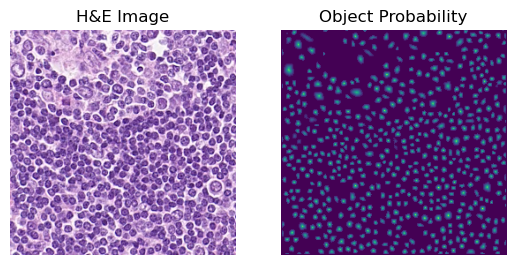

In [5]:
test_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=1)
data = next(iter(test_loader))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('H&E Image')  
plt.imshow(data[0][0].permute(1,2,0))
plt.subplot(1,2,2)
plt.axis('off')
plt.title('Object Probability') 
plt.imshow(data[1][0])
plt.show()


In [6]:
image, obj_prob, star_distances, star_angles = data

## visualize "star points" from data loader

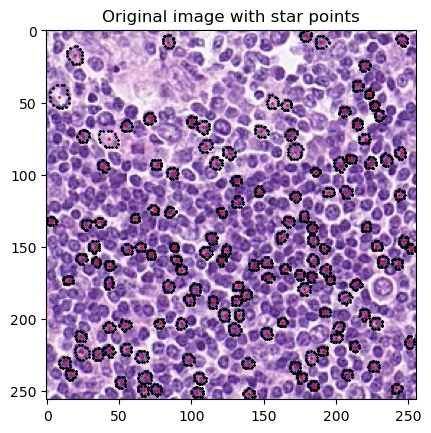

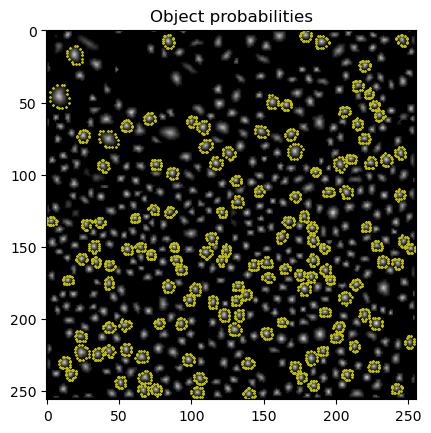

In [7]:
visualize(image[0], obj_prob[0], star_distances[0], star_angles[0])

In [9]:
print(star_distances[0].shape)
print(star_angles[0].shape)

torch.Size([256, 256, 16])
torch.Size([256, 256, 16])


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = PretrainedUNet().to(device)
model1 = output_maps(n_rays=n_rays).to(device)

c:\Users\nisch\.conda\envs\cv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nisch\.conda\envs\cv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
#Hyperparameters taken from paper:
batch_size = config['batch_size']
lr = config['lr']
num_epochs = config['num_epochs']
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss1 = torch.nn.BCEWithLogitsLoss()
loss2 = torch.nn.MSELoss(reduction='none')
loss3 = CircularAELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.5, patience=3, verbose=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=6)

In [13]:
# cuda clear cache
torch.cuda.empty_cache()


## Training loop

In [15]:
# save training loss
obj_prob_loss_epoch_train = []
dist_loss_epoch_train = []
angles_loss_epoch_train = []
total_loss_epoch_train = []
# save validation loss  
obj_prob_loss_epoch_val = []
dist_loss_epoch_val = []
angles_loss_epoch_val = []
total_loss_epoch_val = []
num_batches_train = len(train_loader)
num_batches_val = len(val_loader) 
# training loop 
for epoch in (range(num_epochs)):
    print("Epoch: {}".format(epoch))
    obj_prob_running_loss = 0.0
    dist_running_loss = 0.0
    angles_running_loss = 0.0
    total_running_loss = 0.0
    print("Train")
    model.train()
    for i, data in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        images, object_probabilities, star_poly_dist, star_angles = data
        images, object_probabilities, star_poly_dist, star_angles = images.to(device), object_probabilities.to(device), star_poly_dist.to(device), star_angles.to(device)
        # pdb.set_trace()
        outputs = model(images)
        pred_prob, pred_dist, pred_angles = model1(outputs)
        obj_prob_loss = loss1(pred_prob.squeeze(1), object_probabilities)
        dist_loss = torch.mean(loss2(pred_dist, star_poly_dist.permute(0,3,1,2)) * object_probabilities.unsqueeze(1))
        angles_loss = torch.mean(loss3(pred_angles, star_angles.permute(0,3,1,2)) * object_probabilities.unsqueeze(1))
        loss = obj_prob_loss + dist_loss + angles_loss
        # pdb.set_trace()
        loss.backward()
        optimizer.step()
        obj_prob_running_loss += obj_prob_loss.item()
        dist_running_loss += dist_loss.item()
        angles_running_loss += angles_loss.item()
        total_running_loss += loss.item()
    obj_prob_loss_epoch_train.append(obj_prob_running_loss/num_batches_train)
    dist_loss_epoch_train.append(dist_running_loss/num_batches_train)
    angles_loss_epoch_train.append(angles_running_loss/num_batches_train)
    total_loss_epoch_train.append(total_running_loss/num_batches_train)
    print("Object Probability Loss: {}, Distance Loss: {}, Angle loss: {}, Total loss: {}".format(obj_prob_loss_epoch_train[-1], dist_loss_epoch_train[-1], angles_loss_epoch_train[-1],total_loss_epoch_train[-1]))


    model.eval()
    with torch.no_grad():
        obj_prob_running_loss = 0.0
        dist_running_loss = 0.0
        angles_running_loss = 0.0
        total_running_loss = 0.0
        print("Validation")
        for i, data in enumerate(val_loader):
            images, object_probabilities, star_poly_dist, star_angles = data
            images, object_probabilities, star_poly_dist, star_angles = images.to(device), object_probabilities.to(device), star_poly_dist.to(device), star_angles.to(device)
            outputs = model(images)
            pred_prob, pred_dist,pred_angles = model1(outputs)
            obj_prob_loss = loss1(pred_prob.squeeze(1), object_probabilities)
            dist_loss = torch.mean(loss2(pred_dist, star_poly_dist.permute(0,3,1,2)) * object_probabilities.unsqueeze(1))
            angles_loss = torch.mean(loss3(pred_angles, star_angles.permute(0,3,1,2)) * object_probabilities.unsqueeze(1))
            loss = obj_prob_loss + dist_loss + angles_loss
            obj_prob_running_loss += obj_prob_loss.item()
            dist_running_loss += dist_loss.item()
            angles_running_loss += angles_loss.item()
            total_running_loss += loss.item()
        obj_prob_loss_epoch_val.append(obj_prob_running_loss/num_batches_val)
        dist_loss_epoch_val.append(dist_running_loss/num_batches_val)
        angles_loss_epoch_val.append(angles_running_loss/num_batches_val)
        total_loss_epoch_val.append(total_running_loss/num_batches_val)
        scheduler.step(total_loss_epoch_val[-1])
        print("Object Probability Loss: {}, Distance Loss: {}, Angle loss: {}, Total loss: {}".format(obj_prob_loss_epoch_val[-1], dist_loss_epoch_val[-1], angles_loss_epoch_val[-1],total_loss_epoch_val[-1]))

            


Epoch: 0
Train


24it [01:01,  2.55s/it]


Object Probability Loss: 0.1240855638558666, Distance Loss: 0.5682241568962733, Angle loss: 0.0046779300610069185, Total loss: 0.6969876413544019
Validation
Object Probability Loss: 0.09602847695350647, Distance Loss: 0.26007822901010513, Angle loss: 0.0048615381044025225, Total loss: 0.3609682371218999
Epoch: 1
Train


24it [01:01,  2.56s/it]


Object Probability Loss: 0.09645549952983856, Distance Loss: 0.4234463485578696, Angle loss: 0.004940363627004747, Total loss: 0.5248422082513571
Validation
Object Probability Loss: 0.08657197033365567, Distance Loss: 0.2267684464653333, Angle loss: 0.004771951236762106, Total loss: 0.3181123634179433
Epoch: 2
Train


24it [01:01,  2.56s/it]


Object Probability Loss: 0.08842734961460035, Distance Loss: 0.3940283451229334, Angle loss: 0.0048912774461011095, Total loss: 0.4873469720284144
Validation
Object Probability Loss: 0.08273591846227646, Distance Loss: 0.205519529680411, Angle loss: 0.004806051263585687, Total loss: 0.293061504761378
Epoch: 3
Train


24it [00:59,  2.48s/it]


Object Probability Loss: 0.08323888760060072, Distance Loss: 0.36732393751541775, Angle loss: 0.004794622655026615, Total loss: 0.45535744975010556
Validation
Object Probability Loss: 0.08085683112343152, Distance Loss: 0.20676138252019882, Angle loss: 0.004600174725055695, Total loss: 0.2922183896104495
Epoch: 4
Train


24it [01:03,  2.64s/it]


Object Probability Loss: 0.08030269884814818, Distance Loss: 0.3656480172649026, Angle loss: 0.004537504699934895, Total loss: 0.45048822027941543
Validation
Object Probability Loss: 0.07814613605539004, Distance Loss: 0.20034166673819223, Angle loss: 0.004311690495039026, Total loss: 0.28279949476321536


In [ ]:
# save model dict
torch.save(model.state_dict(), './output/weights/model.pth')
torch.save(model1.state_dict(), './output/weights/model1.pth')

## Inference

In [16]:
test_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=1)

In [53]:
model.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, object_probabilities, star_poly_dist, star_angles = data
        images, object_probabilities, star_poly_dist, star_angles = images.to(device), object_probabilities.to(device), star_poly_dist.to(device), star_angles.to(device)
        outputs = model(images)
        pred_prob, pred_dist, pred_angles = model1(outputs)
        pred_prob = torch.sigmoid(pred_prob)

        break

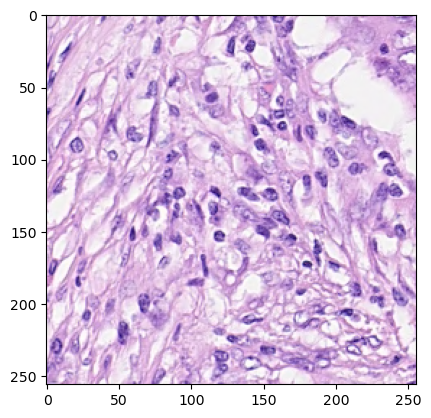

In [54]:
plt.imshow(images[0].permute(1,2,0).cpu().numpy())

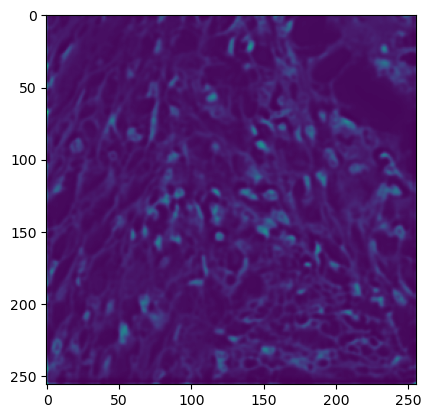

In [55]:
plt.imshow(pred_prob[0].cpu().numpy().squeeze(0))

In [56]:
pred_prob = pred_prob[0].cpu().numpy().squeeze()

In [48]:
pred_prob[:,:20] = 0
pred_prob[:,-20:] = 0
pred_prob[:20,:] = 0
pred_prob[-20:,:] = 0

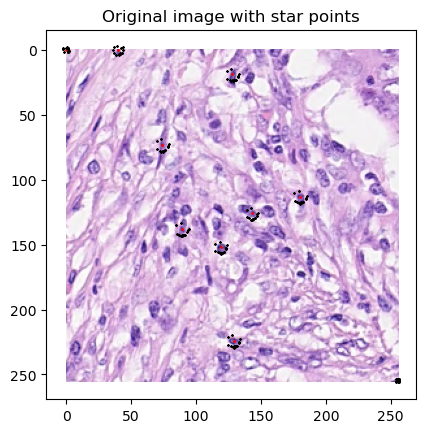

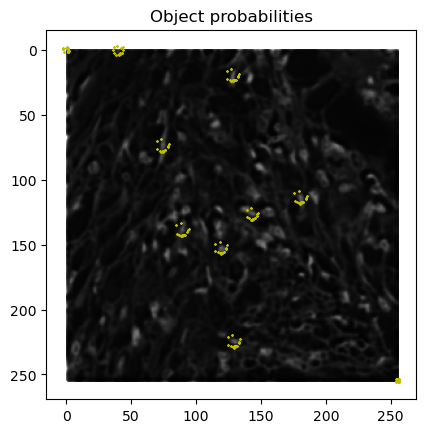

In [57]:
visualize(images[0].cpu(), pred_prob, pred_dist[0].cpu().permute(1,2,0), pred_angles[0].cpu().permute(1,2,0))